In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Fetching data using Yfinance API

In [2]:
df = yf.download('AAPL', start='2015-01-01', end='2024-12-31', auto_adjust=True)
df.reset_index(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2015-01-02,24.288578,24.757332,23.848704,24.746224,212818400
1,2015-01-05,23.604328,24.137509,23.417716,24.057531,257142000
2,2015-01-06,23.606558,23.866483,23.244438,23.668762,263188400
3,2015-01-07,23.937574,24.037545,23.704307,23.815387,160423600
4,2015-01-08,24.857313,24.915075,24.148627,24.266372,237458000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        2515 non-null   datetime64[ns]
 1   (Close, AAPL)   2515 non-null   float64       
 2   (High, AAPL)    2515 non-null   float64       
 3   (Low, AAPL)     2515 non-null   float64       
 4   (Open, AAPL)    2515 non-null   float64       
 5   (Volume, AAPL)  2515 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.0 KB


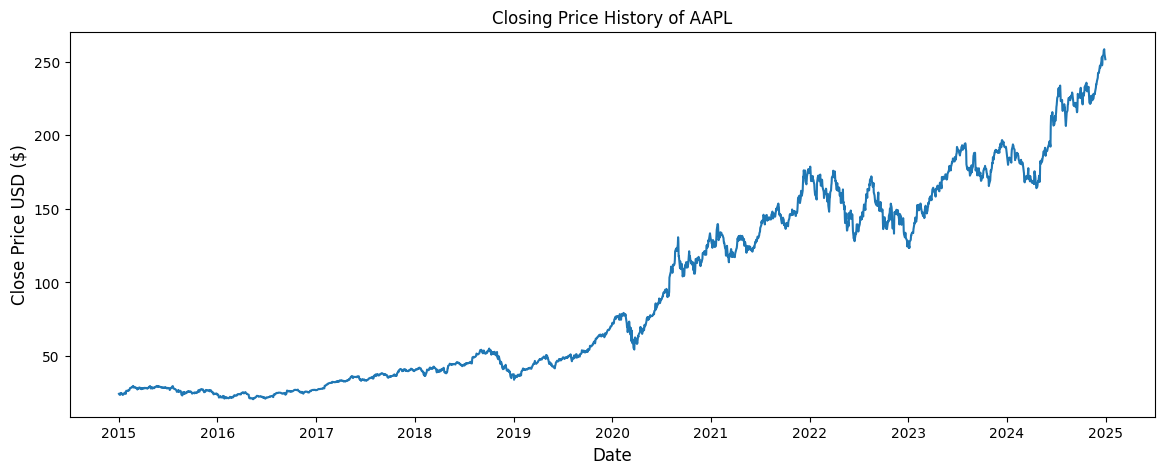

In [4]:
plt.figure(figsize=(14,5))
plt.title('Closing Price History of AAPL')
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.show()

In [5]:
data = df[['Date', 'Close']]
data.set_index('Date', inplace=True)
data.head(3)

Price,Close
Ticker,AAPL
Date,
2015-01-02,24.288578
2015-01-05,23.604328
2015-01-06,23.606558


### Checking for outliers using IQR Method and applying normalization

In [6]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


Number of outliers: 0


In [7]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
print(X.shape)

(2455, 60)


In [8]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Building LSTM Model

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
model.fit(X_train, y_train, epochs=10, batch_size=64)


Epoch 1/10
31/31 [==============================] - 9s 91ms/step - loss: 0.0067
Epoch 2/10
31/31 [==============================] - 3s 83ms/step - loss: 4.1388e-04
Epoch 3/10
31/31 [==============================] - 3s 83ms/step - loss: 2.8673e-04
Epoch 4/10
31/31 [==============================] - 3s 84ms/step - loss: 2.8111e-04
Epoch 5/10
31/31 [==============================] - 3s 83ms/step - loss: 2.7002e-04
Epoch 6/10
31/31 [==============================] - 3s 84ms/step - loss: 2.7660e-04
Epoch 7/10
31/31 [==============================] - 3s 85ms/step - loss: 2.6765e-04
Epoch 8/10
31/31 [==============================] - 3s 84ms/step - loss: 2.5596e-04
Epoch 9/10
31/31 [==============================] - 3s 85ms/step - loss: 2.4775e-04
Epoch 10/10
31/31 [==============================] - 3s 85ms/step - loss: 2.4567e-04


In [12]:
model.save_weights('model_weights.h5')

In [13]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


16/16 [==============================] - 2s 21ms/step


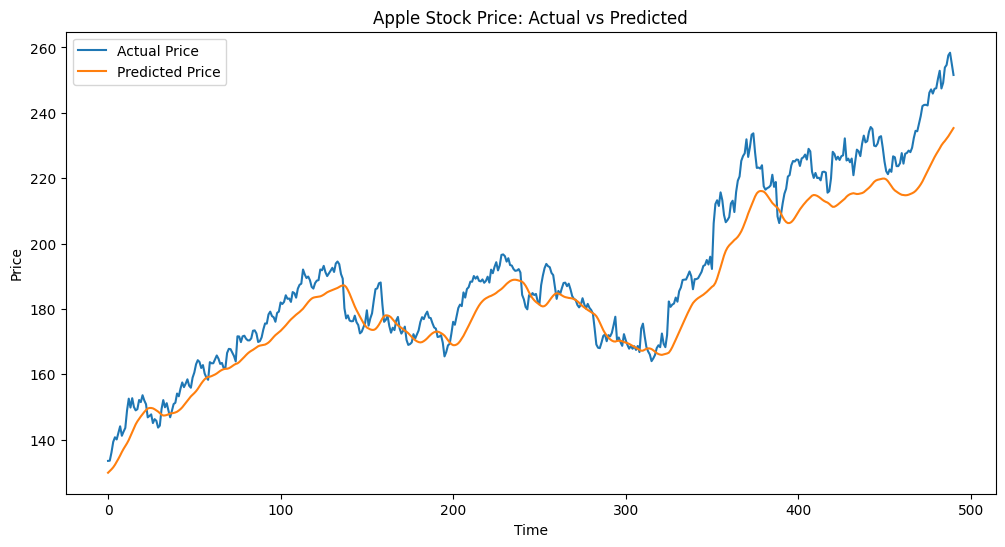

In [14]:
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('Apple Stock Price: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import r2_score
r2 = r2_score(actual_prices, predicted_prices)*100
print(r2)

87.66681175108972


In [16]:
df['MA20'] = df['Close'].rolling(window=20).mean()

In [17]:
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

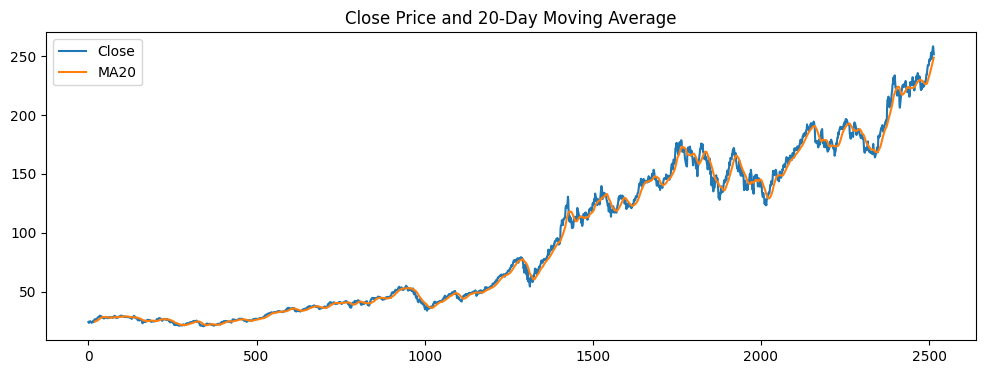

In [18]:
plt.figure(figsize=(12,4))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA20'], label='MA20')
plt.title('Close Price and 20-Day Moving Average')
plt.legend()
plt.show()

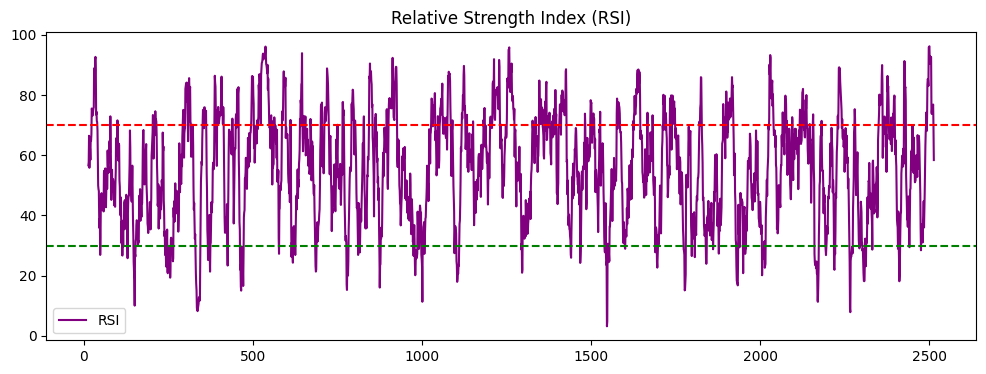

In [19]:
plt.figure(figsize=(12,4))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.title('Relative Strength Index (RSI)')
plt.legend()
plt.show()

### Integrating moving average and RSI indicators

In [20]:
data2 = df[['Close', 'MA20', 'RSI']].dropna()
scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2)

In [21]:
def create_multifeature_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i])      
        y.append(dataset[i, 0])               
    return np.array(X), np.array(y)

X2, y2 = create_multifeature_dataset(scaled_data2, time_step=60)
print("X2 shape:", X2.shape)  
print("y2 shape:", y2.shape)

X2 shape: (2436, 60, 3)
y2 shape: (2436,)


In [22]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)

In [23]:
model2 = Sequential()
model2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train2.shape[1], X_train2.shape[2])))
model2.add(LSTM(units=50))
model2.add(Dense(units=1))
model2.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
model2.fit(X_train2, y_train2, epochs=10, batch_size=64)

Epoch 1/10
31/31 [==============================] - 8s 84ms/step - loss: 0.0073
Epoch 2/10
31/31 [==============================] - 3s 83ms/step - loss: 4.1937e-04
Epoch 3/10
31/31 [==============================] - 3s 83ms/step - loss: 3.0611e-04
Epoch 4/10
31/31 [==============================] - 3s 83ms/step - loss: 2.5754e-04
Epoch 5/10
31/31 [==============================] - 3s 84ms/step - loss: 2.3437e-04
Epoch 6/10
31/31 [==============================] - 3s 84ms/step - loss: 2.2657e-04
Epoch 7/10
31/31 [==============================] - 3s 82ms/step - loss: 2.1360e-04
Epoch 8/10
31/31 [==============================] - 3s 82ms/step - loss: 2.1465e-04
Epoch 9/10
31/31 [==============================] - 3s 82ms/step - loss: 1.9628e-04
Epoch 10/10
31/31 [==============================] - 3s 82ms/step - loss: 1.9515e-04


In [25]:
model2.save_weights('model_weights2.h5')

In [26]:
predicted2 = model2.predict(X_test2)
predicted_full = np.concatenate([predicted2, 
                                 np.zeros((predicted2.shape[0], 2))], axis=1)
actual_full = np.concatenate([y_test2.reshape(-1, 1), 
                              np.zeros((y_test2.shape[0], 2))], axis=1)

predicted_prices2 = scaler2.inverse_transform(predicted_full)[:, 0]
actual_prices2 = scaler2.inverse_transform(actual_full)[:, 0]

16/16 [==============================] - 2s 21ms/step


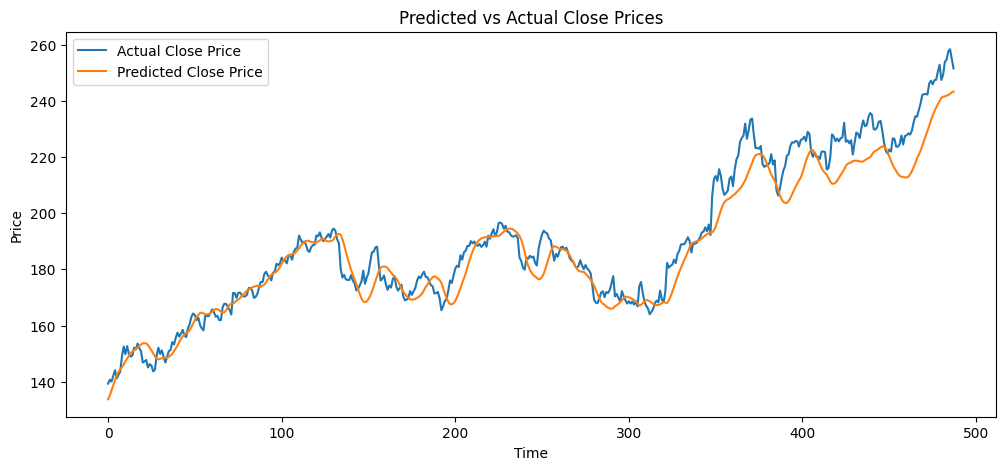

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(actual_prices2, label='Actual Close Price')
plt.plot(predicted_prices2, label='Predicted Close Price')
plt.title('Predicted vs Actual Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
r2_2 = r2_score(actual_prices2, predicted_prices2)*100
print(r2_2)

92.37368353572172
